In [1]:
import warnings
warnings.filterwarnings("ignore")

import pandas as pd
import numpy as np
from dotenv import load_dotenv
import mlflow
import optuna
import matplotlib.pyplot as plt
import seaborn as sns
import json
import joblib

In [2]:
#Unprocessed (unscaled data)

raw_train_df = pd.read_csv("train/splits/train_split.csv")
raw_test_df = pd.read_csv("train/splits/test_split.csv")
raw_val_df = pd.read_csv("train/splits/val_split.csv")

In [3]:
raw_train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 77437 entries, 0 to 77436
Data columns (total 54 columns):
 #   Column                              Non-Null Count  Dtype  
---  ------                              --------------  -----  
 0   msno                                77437 non-null  object 
 1   city                                77437 non-null  float64
 2   bd                                  77437 non-null  float64
 3   gender                              77437 non-null  object 
 4   registered_via                      77437 non-null  float64
 5   registration_init_time              77437 non-null  object 
 6   num_25_mean                         77437 non-null  float64
 7   num_50_mean                         77437 non-null  float64
 8   num_50_min                          77437 non-null  float64
 9   num_50_max                          77437 non-null  float64
 10  num_50_std                          77437 non-null  float64
 11  num_75_mean                         77437

In [4]:
raw_train_df.head()

msno  city    bd  gender  \
0  P7W1hJVPC9+lZf5WLhskxKvQQEJJdpKkKVu4v7RA0zQ=  13.0  29.0  female   
1  yKDUvz1yO1xZ/fwG0bMyIa5K+w7+kIAc+qV3vZKYz9E=  22.0  36.0  female   
2  STy1UqGkW8U4LNr6usNMy5hpCt1fZs96eLFHmhnb0tE=  10.0  32.0  female   
3  35OTDI3ToY0rj1BtWTbDJ9YV8yDygsv1sNM08SQ7pQc=  22.0  33.0  female   
4  9CqDxOPBQwLzxCOywM3l763Yq4yFQhPhFFk79rPs5x0=   5.0   0.0    male   

   registered_via registration_init_time  num_25_mean  num_50_mean  \
0             9.0             2004-03-26         2.86         0.00   
1             9.0             2004-03-26         2.00         0.50   
2             9.0             2004-03-26         3.00         0.50   
3             9.0             2004-03-26         4.17         0.86   
4             9.0             2004-03-26         4.11         3.83   

   num_50_min  num_50_max  ...  membership_expire_day_of_week_mean  \
0         0.0         0.0  ...                                 3.0   
1         0.0         1.0  ...                                 5.0   
2         0.0         1.0  ...                                 6.0   
3         0.0         3.0  ...                                 6.0   
4         0.0        19.0  ...                                 0.0   

   membership_expire_month_mean  membership_expire_month_count  \
0                           4.0                            1.0   
1                           4.5                            2.0   
2                           4.0                            1.0   
3                           4.0                            1.0   
4                           4.0                            1.0   

   last_transaction_date  is_churn  registration_year  registration_month  \
0             2017-03-01       0.0             2004.0                 3.0   
1             2017-03-31       0.0             2004.0                 3.0   
2             2017-03-31       0.0             2004.0                 3.0   
3             2017-03-31       0.0             2004.0                 3.0   
4             2017-03-17       0.0             2004.0                 3.0   

   last_transaction_year  last_transaction_month  usage_period_days  
0                 2017.0                     3.0             4723.0  
1                 2017.0                     3.0             4753.0  
2                 2017.0                     3.0             4753.0  
3                 2017.0                     3.0             4753.0  
4                 2017.0                     3.0             4739.0  

[5 rows x 54 columns]

## Preprocessing


In [7]:
TO_DROP = ["msno", "registration_init_time", "last_transaction_date"]
CATEGORICAL_FEATS = ["city", "gender", "registered_via", "registration_month", "last_transaction_month"]

def preprocess_df(df : pd.DataFrame):

    df_cp = df.copy()
    df_cp = df_cp.drop(TO_DROP, axis=1)
    
    for name in CATEGORICAL_FEATS:
        df_cp[name] = df_cp[name].astype("category")


    return df_cp


In [8]:
#Apply preprocessing
train_df = preprocess_df(raw_train_df)
val_df = preprocess_df(raw_val_df)
test_df = preprocess_df(raw_test_df)

## Feature Processing

### Feature Importance Filtering
Looking at Feature Importances produced in first iteration, let's drop the most uninoformative ones.

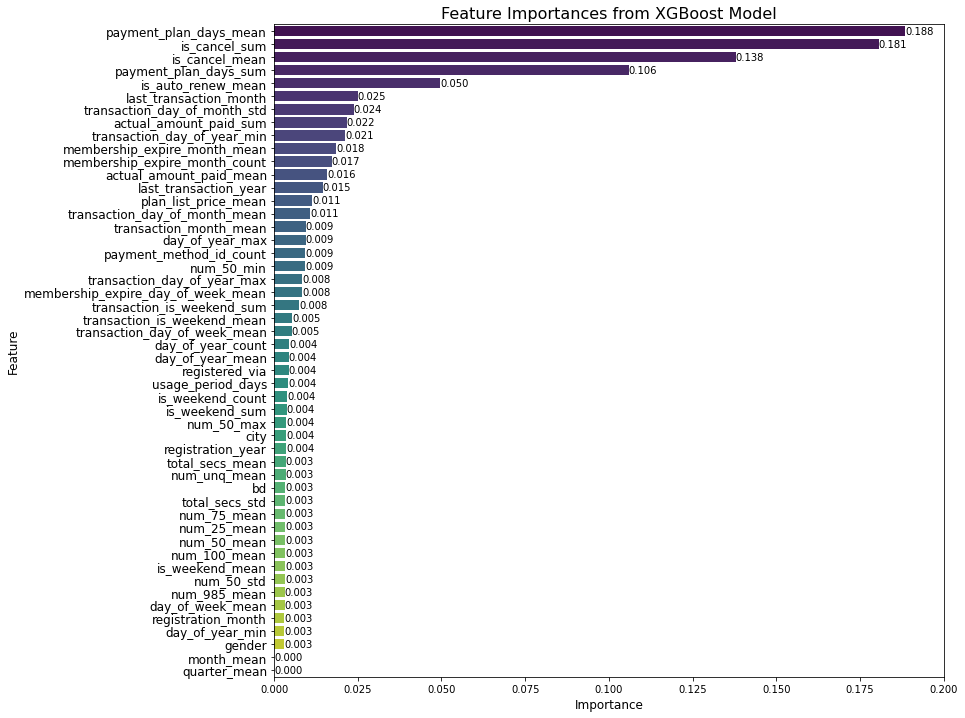

In [9]:
fi_df = pd.read_csv("artifacts/xgb_feat_importances_iter1.csv")

plt.figure(figsize=(12, 12))
sns.barplot(x="importance", y="feature", data=fi_df, palette="viridis")

for index, value in enumerate(fi_df["importance"]):
    plt.text(value, index, f'{value:.3f}', va='center')

plt.title('Feature Importances from XGBoost Model', fontsize=16)
plt.xlabel('Importance', fontsize=12)
plt.yticks(fontsize=12)
plt.ylabel('Feature', fontsize=12)
plt.xlim(0, 0.2)
plt.show()


In [10]:
fi_treshold = 0.0035

IMPORTANT_FEATURES = fi_df[fi_df["importance"] >= fi_treshold]["feature"].to_list()

print("Number of Important features left:", len(IMPORTANT_FEATURES))

Number of Important features left: 33


In [11]:
train_df_filt = train_df[IMPORTANT_FEATURES + ["is_churn"]]
val_df_filt = val_df[IMPORTANT_FEATURES + ["is_churn"]]
test_df_filt = test_df[IMPORTANT_FEATURES + ["is_churn"]]

In [12]:
train_df_filt.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 77437 entries, 0 to 77436
Data columns (total 34 columns):
 #   Column                              Non-Null Count  Dtype   
---  ------                              --------------  -----   
 0   payment_plan_days_mean              77437 non-null  float64 
 1   is_cancel_sum                       77437 non-null  float64 
 2   is_cancel_mean                      77437 non-null  float64 
 3   payment_plan_days_sum               77437 non-null  float64 
 4   is_auto_renew_mean                  77437 non-null  float64 
 5   last_transaction_month              77437 non-null  category
 6   transaction_day_of_month_std        77437 non-null  float64 
 7   actual_amount_paid_sum              77437 non-null  float64 
 8   transaction_day_of_year_min         77437 non-null  float64 
 9   membership_expire_month_mean        77437 non-null  float64 
 10  membership_expire_month_count       77437 non-null  float64 
 11  actual_amount_paid_mean     

### Feature Correlation: Multicollinearity 

<Axes: title={'center': 'Correlation for Filtered DF'}>

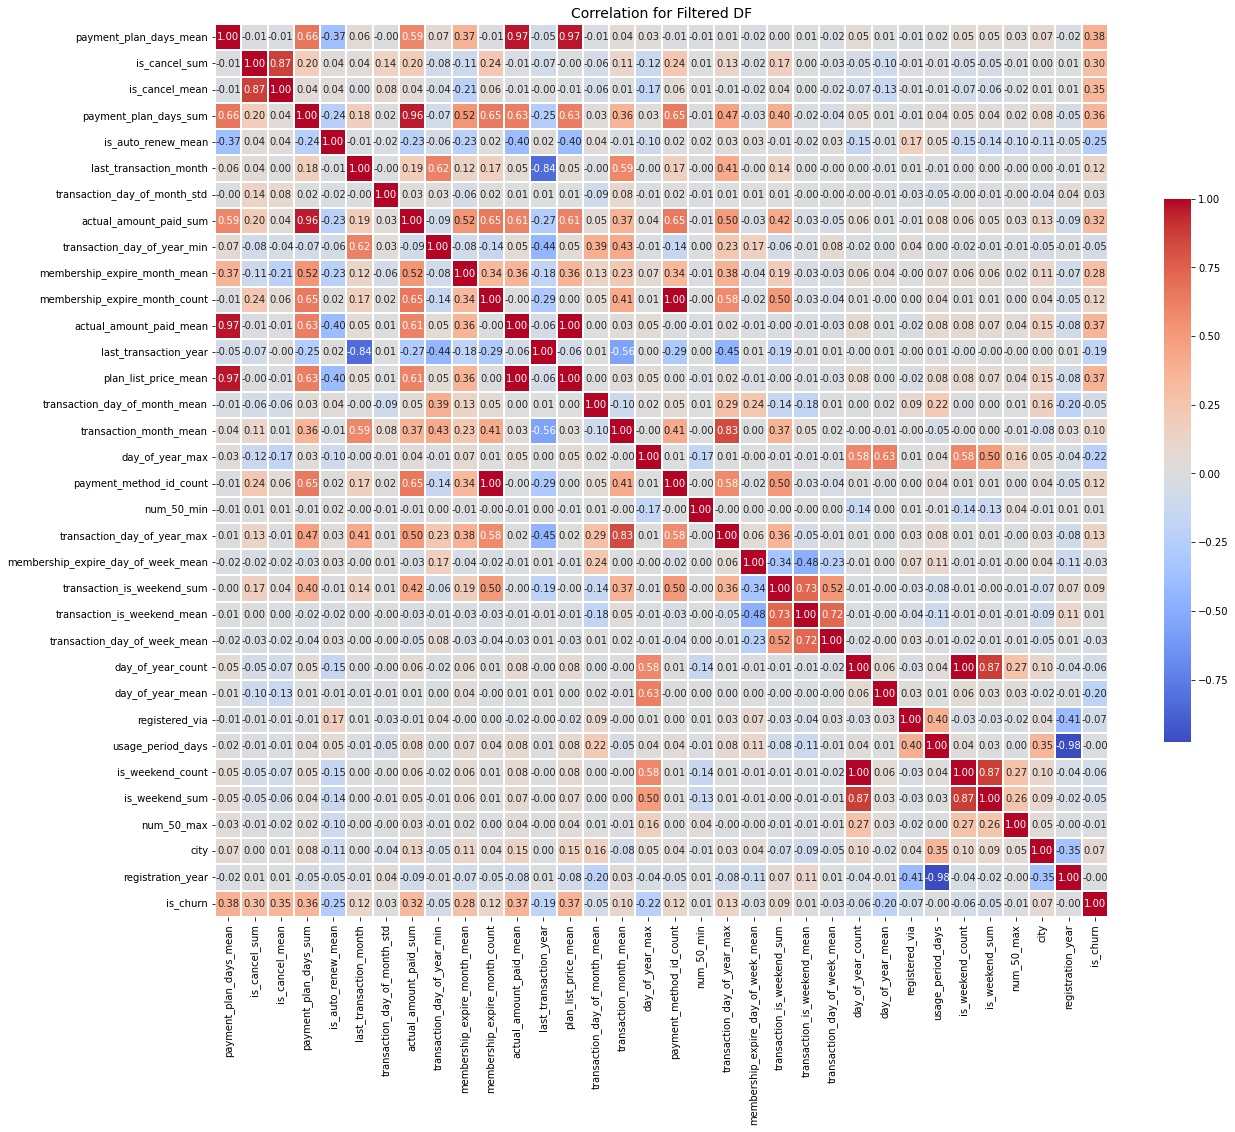

In [13]:
corr_matrix = train_df_filt.corr()
plt.figure(figsize=(20, 20))
plt.title("Correlation for Filtered DF", fontsize=14)
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap='coolwarm', square=True, linewidths=1.5, cbar_kws={"shrink": 0.5})

**Observation:**

We clearly see that we have a **mutlicollinearity problem** because of the way we aggregated data (mean of some sample is highly correlated to sum as example). Some features are redundant because correlation is nearly 1 (e.g. payment plan days sum and actual_amount_paid_sum)

This is not a big problem in terms of performance of boosting algorithms, but it is an **issue in terms of interpretability**

In [14]:
# Create a boolean mask for the upper triangle of the correlation matrix
# Exclude the diagonal (k=1) and lower triangle, keeping only the upper triangle

high_corr_treshold = 0.75

upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool_))

# Identify the features that have a high correlation (> t) with any other feature
REDUNDANT_TO_DROP = [column for column in upper.columns if any(np.abs(upper[column]) > high_corr_treshold)]

REDUNDANT_TO_DROP

['is_cancel_mean',
 'actual_amount_paid_sum',
 'actual_amount_paid_mean',
 'last_transaction_year',
 'plan_list_price_mean',
 'payment_method_id_count',
 'transaction_day_of_year_max',
 'is_weekend_count',
 'is_weekend_sum',
 'registration_year']

In [15]:
#Remove redundant features to reduce multicolinearity

train_df_reduced = train_df_filt.drop(REDUNDANT_TO_DROP, axis=1)
val_df_reduced = val_df_filt.drop(REDUNDANT_TO_DROP, axis=1)
test_df_reduced = test_df_filt.drop(REDUNDANT_TO_DROP, axis=1)

**Looking at correlation  matrix again**

<Axes: title={'center': 'Correlation for Filtered DF without Redundant Features'}>

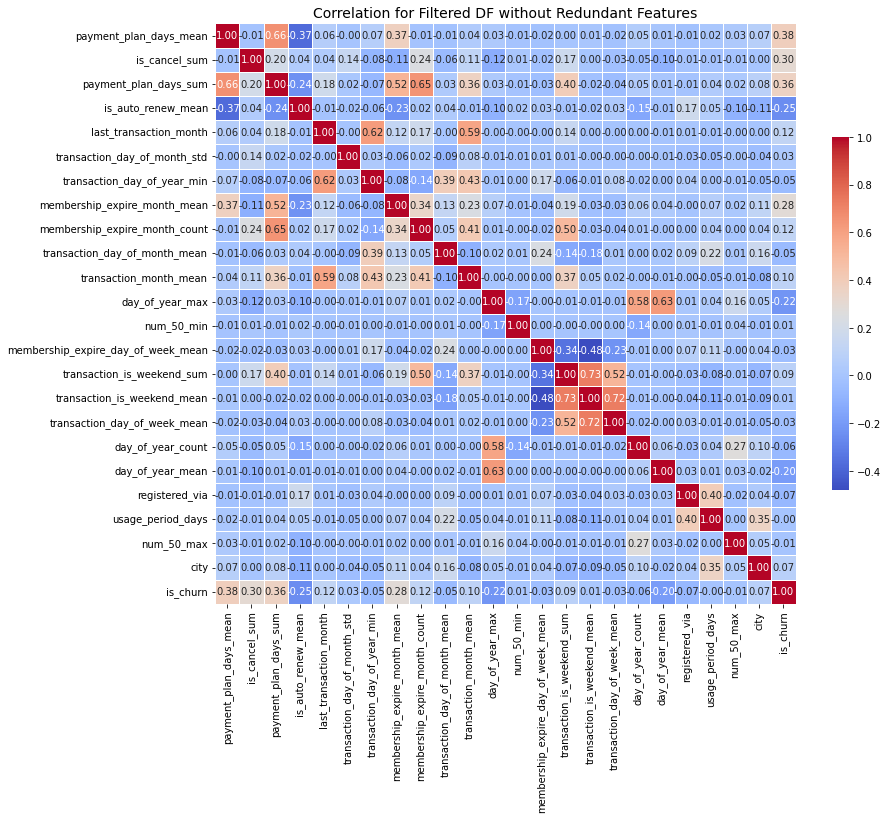

In [16]:
corr_matrix_red = train_df_reduced.corr()
plt.figure(figsize=(13, 13))
plt.title("Correlation for Filtered DF without Redundant Features", fontsize=14)
sns.heatmap(corr_matrix_red, annot=True, fmt=".2f", cmap='coolwarm', square=True, linewidths=1, cbar_kws={"shrink": 0.5})

Now, it looks much better because we don't have extremely correlated features. This step shouldn't hurt the performance of ml model, but it **will certainly improve or ability to interpret model's decision**

In [17]:
train_df_reduced.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 77437 entries, 0 to 77436
Data columns (total 24 columns):
 #   Column                              Non-Null Count  Dtype   
---  ------                              --------------  -----   
 0   payment_plan_days_mean              77437 non-null  float64 
 1   is_cancel_sum                       77437 non-null  float64 
 2   payment_plan_days_sum               77437 non-null  float64 
 3   is_auto_renew_mean                  77437 non-null  float64 
 4   last_transaction_month              77437 non-null  category
 5   transaction_day_of_month_std        77437 non-null  float64 
 6   transaction_day_of_year_min         77437 non-null  float64 
 7   membership_expire_month_mean        77437 non-null  float64 
 8   membership_expire_month_count       77437 non-null  float64 
 9   transaction_day_of_month_mean       77437 non-null  float64 
 10  transaction_month_mean              77437 non-null  float64 
 11  day_of_year_max             

## Model Training

### Logistic Regression

In [18]:
X_train, y_train = train_df_reduced.drop("is_churn", axis=1), train_df_reduced["is_churn"]
X_val, y_val = val_df_reduced.drop("is_churn", axis=1), val_df_reduced["is_churn"]
X_test, y_test = test_df_reduced.drop("is_churn", axis=1), test_df_reduced["is_churn"]

In [19]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import precision_score, recall_score, f1_score
from optuna.visualization import plot_optimization_history, plot_param_importances, plot_slice, plot_parallel_coordinate

def plot_optuna_visualizations(study):
    # Plot optimization history
    print("Optimization History:")
    fig1 = plot_optimization_history(study)
    fig1.show()
    
    # Plot parameter importances
    print("Parameter Importances:")
    fig2 = plot_param_importances(study)
    fig2.show()
    



def classification_report(y_true, y_pred, modelname):
    
    precision = precision_score(y_true, y_pred, average='binary')
    recall = recall_score(y_true, y_pred, average='binary')
    f1 = f1_score(y_true, y_pred, average='binary')

    print("====Classification Report for model:", modelname, "=========")
    print(f"Precision: {precision:.4f}")
    print(f"Recall:    {recall:.4f}")
    print(f"F1 Score:  {f1:.4f}")


def find_best_threshold(y_true, y_probs):
    """
    Finds the best threshold for predicted probabilities to optimize F1 score.
    """
    best_threshold = 0.0
    best_f1 = 0.0

    # Evaluate F1 score for thresholds between 0.0 and 1.0
    for threshold in np.linspace(0, 1, 101):
        y_pred = (y_probs >= threshold).astype(int)
        current_f1 = f1_score(y_true, y_pred)
        
        if current_f1 > best_f1:
            best_f1 = current_f1
            best_threshold = threshold

    return best_threshold    


logreg = LogisticRegression(random_state=2, l1_ratio=0.3, max_iter=5000)
logreg.fit(X_train, y_train)

clf_t = find_best_threshold(y_val, logreg.predict_proba(X_val)[:, 1])
y_pred = (logreg.predict_proba(X_val)[:, 1] >= clf_t).astype(int)

classification_report(y_val, y_pred, modelname="Logistic Regression")

====Classification Report for model: Logistic Regression =========
Precision: 0.5939
Recall:    0.7249
F1 Score:  0.6529


###  XGBoost model

In [20]:
from xgboost import XGBClassifier

def xgb_objective(trial):

    param = {
        'max_depth': trial.suggest_int('max_depth', 1, 10),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 1.0),
        'n_estimators': trial.suggest_int('n_estimators', 50, 800),
        'min_child_weight': trial.suggest_int('min_child_weight', 1, 10),
        'gamma': trial.suggest_float('gamma', 1e-8, 1.0, log=True),
        'subsample': trial.suggest_float('subsample', 0.01, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.01, 1.0, log=True),
        'reg_alpha': trial.suggest_float('reg_alpha', 1e-8, 1.0, log=True),
        'reg_lambda': trial.suggest_float('reg_lambda', 1e-8, 1.0, log=True),
        'eval_metric': 'mlogloss',
        'use_label_encoder': False,
        'enable_categorical': True 
        #'device' : 'cuda'
    }


    clf = XGBClassifier(**param)
    clf.fit(X_train, y_train)
    clf_probs = clf.predict_proba(X_val)[:, 1]
    
    best_t = find_best_threshold(y_val, clf_probs)
    clf_predicts = (clf_probs >= best_t).astype(int)

    f1_metric = f1_score(y_val, clf_predicts)
    
    return f1_metric
    


xgb_study = optuna.create_study(direction="maximize")
xgb_study.optimize(xgb_objective, n_trials=30, timeout=2400)

xgb_trial = xgb_study.best_trial
print(f'Best trial for Gradient Boosting: {xgb_trial.params}')

xgb_study_df = xgb_study.trials_dataframe()
xgb_study_df.to_csv("xgb_study_f1_iter2.csv", index=False)

[I 2024-08-30 19:56:55,600] A new study created in memory with name: no-name-da7b4952-c4e6-4a8a-a878-246de36496a5
[I 2024-08-30 19:57:02,709] Trial 0 finished with value: 0.8022598870056497 and parameters: {'max_depth': 8, 'learning_rate': 0.09622305225249878, 'n_estimators': 748, 'min_child_weight': 9, 'gamma': 0.0022579592500587557, 'subsample': 0.6202305967325789, 'colsample_bytree': 0.08253299321304979, 'reg_alpha': 0.3985761333474238, 'reg_lambda': 1.6398955778699474e-06}. Best is trial 0 with value: 0.8022598870056497.
[I 2024-08-30 19:57:10,845] Trial 1 finished with value: 0.7772925764192141 and parameters: {'max_depth': 8, 'learning_rate': 0.9427830536690709, 'n_estimators': 786, 'min_child_weight': 7, 'gamma': 1.5104360835490888e-06, 'subsample': 0.5773614175560173, 'colsample_bytree': 0.7992759785513132, 'reg_alpha': 0.07159376487195336, 'reg_lambda': 9.371776959952434e-06}. Best is trial 0 with value: 0.8022598870056497.
[I 2024-08-30 19:57:12,340] Trial 2 finished with val

Best trial for Gradient Boosting: {'max_depth': 10, 'learning_rate': 0.2768079694906896, 'n_estimators': 691, 'min_child_weight': 10, 'gamma': 0.18497721370212403, 'subsample': 0.9957367563895377, 'colsample_bytree': 0.09432684699510813, 'reg_alpha': 1.2135457396738627e-06, 'reg_lambda': 0.006153507109544924}


In [21]:
xgb_best_params = xgb_study.best_params

In [22]:
with open("artifacts/xgb_best_params_iter2.json", "w") as f:
    json.dump(xgb_best_params, f, indent=3)

xgb_best_params

{'max_depth': 10,
 'learning_rate': 0.2768079694906896,
 'n_estimators': 691,
 'min_child_weight': 10,
 'gamma': 0.18497721370212403,
 'subsample': 0.9957367563895377,
 'colsample_bytree': 0.09432684699510813,
 'reg_alpha': 1.2135457396738627e-06,
 'reg_lambda': 0.006153507109544924}

In [23]:
xgb_model = XGBClassifier(**xgb_best_params,
                          eval_metric="mlogloss", enable_categorical=True)
xgb_model.fit(X_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.09432684699510813, device=None,
              early_stopping_rounds=None, enable_categorical=True,
              eval_metric='mlogloss', feature_types=None,
              gamma=0.18497721370212403, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.2768079694906896,
              max_bin=None, max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=10, max_leaves=None,
              min_child_weight=10, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=691, n_jobs=None,
              num_parallel_tree=None, random_state=None, ...)

In [24]:
xgb_model_probs = xgb_model.predict_proba(X_val)[:, 1]
xgb_t = find_best_threshold(y_val, xgb_model_probs)
xgb_preds = (xgb_model_probs >= xgb_t).astype(int)

print("Treshold: ", xgb_t)
classification_report(y_val,  xgb_preds, "XGB")

Treshold:  0.35000000000000003
====Classification Report for model: XGB =========
Precision: 0.8116
Recall:    0.8395
F1 Score:  0.8254


Optimization History:


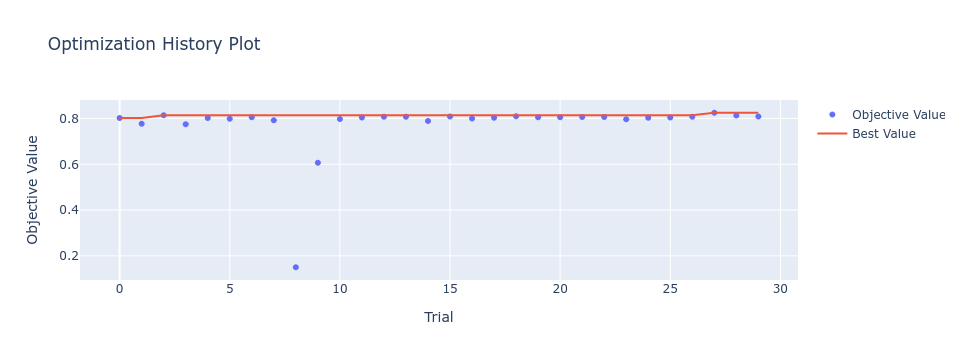

Parameter Importances:


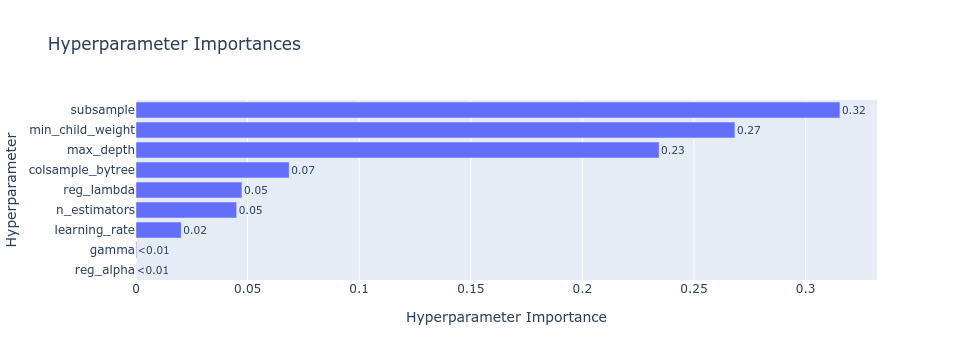

In [25]:
plot_optuna_visualizations(xgb_study)

### LightGBM model

In [26]:
import lightgbm as lgb


def lgbm_objective(trial):
    param = {
        'objective': 'binary',
        'metric': 'auc',
        'verbosity': -1,
        'device' : 'cpu',
        'n_jobs' : -1,
        'boosting_type': 'gbdt',
        'n_estimators': trial.suggest_int('n_estimators', 100, 900),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.2),
        'max_depth': trial.suggest_int('max_depth', 3, 8),
        'num_leaves': trial.suggest_int('num_leaves', 20, 300),
        'min_child_samples': trial.suggest_int('min_child_samples', 5, 100),
        'subsample': trial.suggest_float('subsample', 0.5, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.5, 1.0),
        'reg_alpha': trial.suggest_float('reg_alpha', 0.0, 1.0),
        'reg_lambda': trial.suggest_float('reg_lambda', 0.0, 1.0)
    }

    clf = lgb.LGBMClassifier(**param)

    clf.fit(X_train, y_train)
    clf_probs = clf.predict_proba(X_val)[:, 1]
    
    best_t = find_best_threshold(y_val, clf_probs)
    clf_predicts = (clf_probs >= best_t).astype(int)

    f1_metric = f1_score(y_val, clf_predicts)
    
    return f1_metric


lgbm_study = optuna.create_study(direction="maximize")
lgbm_study.optimize(lgbm_objective, n_trials=30, timeout=2400)

# Best trial
lgbm_trial = lgbm_study.best_trial
print(f'Best trial for Gradient Boosting: {lgbm_trial.params}')

##Saving study
lgbm_study_df = lgbm_study.trials_dataframe()
lgbm_study_df.to_csv("lgbm_study_iter2.csv", index=False)

[I 2024-08-30 19:58:34,998] A new study created in memory with name: no-name-87162675-ded0-47ff-b315-f1cc8a1abad9
[I 2024-08-30 19:58:41,641] Trial 0 finished with value: 0.831275720164609 and parameters: {'n_estimators': 566, 'learning_rate': 0.10325141624712453, 'max_depth': 6, 'num_leaves': 181, 'min_child_samples': 67, 'subsample': 0.9646307977148421, 'colsample_bytree': 0.5065461995918346, 'reg_alpha': 0.7673917448521981, 'reg_lambda': 0.11965597801044248}. Best is trial 0 with value: 0.831275720164609.
[I 2024-08-30 19:58:46,934] Trial 1 finished with value: 0.8312412831241283 and parameters: {'n_estimators': 749, 'learning_rate': 0.10443030586219564, 'max_depth': 3, 'num_leaves': 90, 'min_child_samples': 81, 'subsample': 0.5861996409917681, 'colsample_bytree': 0.6291771816295876, 'reg_alpha': 0.8920055083308132, 'reg_lambda': 0.0755724239772102}. Best is trial 0 with value: 0.831275720164609.
[I 2024-08-30 19:58:56,185] Trial 2 finished with value: 0.8233657858136301 and paramet

Best trial for Gradient Boosting: {'n_estimators': 304, 'learning_rate': 0.0735242251912344, 'max_depth': 6, 'num_leaves': 172, 'min_child_samples': 33, 'subsample': 0.6934982409354034, 'colsample_bytree': 0.5851893612797265, 'reg_alpha': 0.31025696921462553, 'reg_lambda': 0.7242031918694621}


In [27]:
lgbm_best_params = lgbm_study.best_params
lgbm_best_params

{'n_estimators': 304,
 'learning_rate': 0.0735242251912344,
 'max_depth': 6,
 'num_leaves': 172,
 'min_child_samples': 33,
 'subsample': 0.6934982409354034,
 'colsample_bytree': 0.5851893612797265,
 'reg_alpha': 0.31025696921462553,
 'reg_lambda': 0.7242031918694621}

In [28]:
lgbm_model = lgb.LGBMClassifier(**lgbm_best_params, verbose=-1)
lgbm_model.fit(X_train, y_train, )

LGBMClassifier(colsample_bytree=0.5851893612797265,
               learning_rate=0.0735242251912344, max_depth=6,
               min_child_samples=33, n_estimators=304, num_leaves=172,
               reg_alpha=0.31025696921462553, reg_lambda=0.7242031918694621,
               subsample=0.6934982409354034, verbose=-1)

In [29]:
lgbm_val_probs = lgbm_model.predict_proba(X_val)[:, 1]
lgbm_t = find_best_threshold(y_val, lgbm_val_probs)

lgbm_predicts = (lgbm_val_probs > lgbm_t).astype(int)
print("Treshold: ", lgbm_t)
classification_report(y_val, lgbm_predicts, "LGBM")

Treshold:  0.24
====Classification Report for model: LGBM =========
Precision: 0.7888
Recall:    0.8883
F1 Score:  0.8356


In [30]:
plot_optuna_visualizations(lgbm_study)

Optimization History:


Parameter Importances:


### Random Forest


In [31]:
from sklearn.ensemble import RandomForestClassifier

def rf_objective(trial):
    # Define the hyperparameter grid
    n_estimators = trial.suggest_int("n_estimators", 100, 1000)
    max_depth = trial.suggest_int("max_depth", 2, 32, log=True)
    min_samples_split = trial.suggest_int("min_samples_split", 2, 14)
    min_samples_leaf = trial.suggest_int("min_samples_leaf", 1, 14)

    clf = RandomForestClassifier(
        n_estimators=n_estimators,
        max_depth=max_depth,
        min_samples_split=min_samples_split,
        min_samples_leaf=min_samples_leaf,
        random_state=42,
        n_jobs=-1
    )

    clf.fit(X_train, y_train)
    clf_probs = clf.predict_proba(X_val)[:, 1]
    
    best_t = find_best_threshold(y_val, clf_probs)
    clf_predicts = (clf_probs >= best_t).astype(int)

    f1_metric = f1_score(y_val, clf_predicts)
    
    return f1_metric


rf_study = optuna.create_study(direction="maximize")
rf_study.optimize(rf_objective, n_trials=20, timeout=1200)


rf_trial = rf_study.best_trial
print(f'Best trial: {rf_trial.params}')

##Saving study
rf_study_df = rf_study.trials_dataframe()
rf_study_df.to_csv("rf_study_iter2.csv", index=False)

[I 2024-08-30 20:01:16,586] A new study created in memory with name: no-name-e5a775c2-3aea-4515-a5a5-6223ae109212
[I 2024-08-30 20:01:28,380] Trial 0 finished with value: 0.8307692307692307 and parameters: {'n_estimators': 269, 'max_depth': 32, 'min_samples_split': 3, 'min_samples_leaf': 6}. Best is trial 0 with value: 0.8307692307692307.
[I 2024-08-30 20:01:55,326] Trial 1 finished with value: 0.8236914600550964 and parameters: {'n_estimators': 600, 'max_depth': 17, 'min_samples_split': 10, 'min_samples_leaf': 12}. Best is trial 0 with value: 0.8307692307692307.
[I 2024-08-30 20:02:21,108] Trial 2 finished with value: 0.8272980501392757 and parameters: {'n_estimators': 566, 'max_depth': 15, 'min_samples_split': 14, 'min_samples_leaf': 4}. Best is trial 0 with value: 0.8307692307692307.
[I 2024-08-30 20:02:27,722] Trial 3 finished with value: 0.7797062750333777 and parameters: {'n_estimators': 483, 'max_depth': 2, 'min_samples_split': 14, 'min_samples_leaf': 7}. Best is trial 0 with va

Best trial: {'n_estimators': 264, 'max_depth': 20, 'min_samples_split': 5, 'min_samples_leaf': 4}


In [32]:
rf_best_param = rf_study.best_params

print(rf_best_param)

rf_model = RandomForestClassifier(**rf_best_param)
rf_model.fit(X_train, y_train)

{'n_estimators': 264, 'max_depth': 20, 'min_samples_split': 5, 'min_samples_leaf': 4}


RandomForestClassifier(max_depth=20, min_samples_leaf=4, min_samples_split=5,
                       n_estimators=264)

In [33]:
rf_val_probs = rf_model.predict_proba(X_val)[:, 1]

rf_t = find_best_threshold(y_val, rf_val_probs)

rf_predicts = (rf_val_probs >= rf_t).astype(int)

print("Threshold: ", rf_t)
classification_report(y_val, rf_predicts, "Random Forest")


Threshold:  0.24
====Classification Report for model: Random Forest =========
Precision: 0.7887
Recall:    0.8768
F1 Score:  0.8304


In [34]:
joblib.dump(rf_model, "artifacts/rf_model_iter2.joblib")

['artifacts/rf_model_iter2.joblib']

Optimization History:


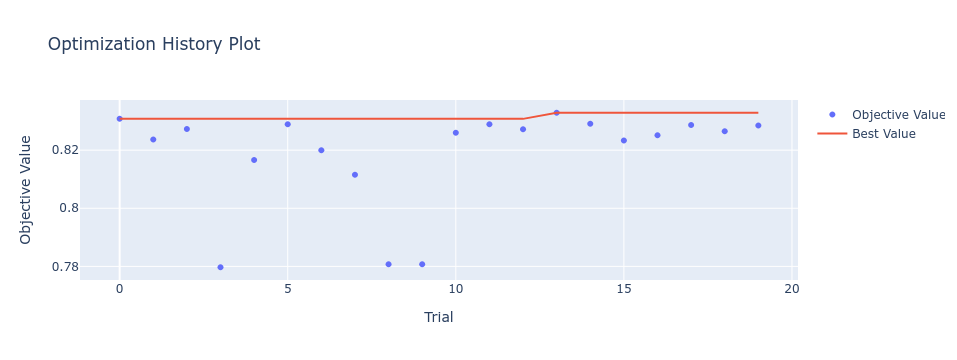

Parameter Importances:


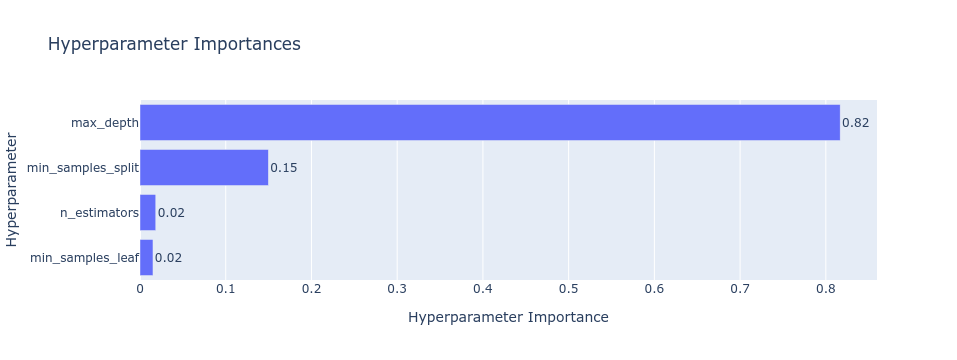

In [35]:
plot_optuna_visualizations(rf_study)

### TODO: 
 - try Catboost and DeepLearning (mb)
 - compare how calibrated models we obtain
 - pick the most performant/calibrated one
 -  Slicing: evaluate models on Slices of data by city, gender, LTV bins

## Calibration 
We need model calibration to make our classifier predict scores that will behave like actual probabilities. Usually, trained classifier predict values near 0 or near 1. Sometimes, we want our predictions to be probabilities. 0.4 - should mean 4 out of 10 


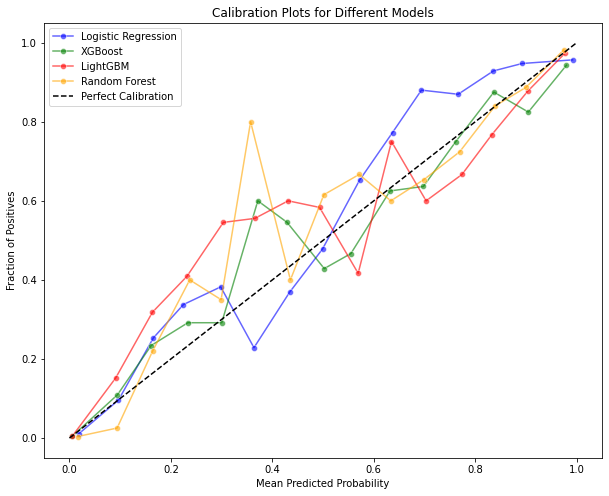

=======EXPECTED CALIBRATION ERROR:==============
ECE for Logistic Regression: 0.0802
ECE for XGBoost: 0.0598
ECE for LightGBM: 0.1106
ECE for Random Forest: 0.0789


In [54]:
from sklearn.calibration import calibration_curve, CalibratedClassifierCV

CALIB_BINS=15

logreg_val_predicts = logreg.predict_proba(X_val)[:, 1]
xgb_model_val_predicts = xgb_model.predict_proba(X_val)[:, 1]
lgbm_model_val_predicts = lgbm_model.predict_proba(X_val)[:, 1]
rf_model_val_predicts = rf_model.predict_proba(X_val)[:, 1]

logreg_prob_true, logreg_prob_pred = calibration_curve(y_val, logreg_val_predicts, n_bins=CALIB_BINS)
xgb_prob_true, xgb_prob_pred = calibration_curve(y_val, xgb_model_val_predicts, n_bins=CALIB_BINS)
lgbm_prob_true, lgbm_prob_pred = calibration_curve(y_val, lgbm_model_val_predicts, n_bins=CALIB_BINS)
rf_prob_true, rf_prob_pred = calibration_curve(y_val, rf_model_val_predicts, n_bins=CALIB_BINS)

plt.figure(figsize=(10, 8))

sns.lineplot(x=logreg_prob_pred, y=logreg_prob_true, marker='o', label='Logistic Regression', color='blue', alpha=0.6)
sns.lineplot(x=xgb_prob_pred, y=xgb_prob_true, marker='o', label='XGBoost', color='green',alpha=0.6)
sns.lineplot(x=lgbm_prob_pred, y=lgbm_prob_true, marker='o', label='LightGBM', color='red',alpha=0.6)
sns.lineplot(x=rf_prob_pred, y=rf_prob_true, marker='o', label='Random Forest', color='orange',alpha=0.6)

plt.plot([0, 1], [0, 1], linestyle='--', color='black', label='Perfect Calibration')


plt.xlabel('Mean Predicted Probability')
plt.ylabel('Fraction of Positives')
plt.title('Calibration Plots for Different Models')
plt.legend(loc='upper left')

plt.show()


def compute_ece(prob_true, prob_pred, n_bins):
    bin_edges = np.linspace(0, 1, n_bins + 1)
    bin_indices = np.digitize(prob_pred, bin_edges, right=True)
    
    ece = 0.0
    for i in range(1, n_bins + 1):
        bin_mask = bin_indices == i
        bin_size = np.sum(bin_mask)
        if bin_size > 0:
            avg_pred_prob = np.mean(prob_pred[bin_mask])
            avg_true_prob = np.mean(prob_true[bin_mask])
            ece += np.abs(avg_pred_prob - avg_true_prob) * (bin_size / len(prob_true))
    return ece

logreg_ece = compute_ece(logreg_prob_true, logreg_prob_pred, n_bins=CALIB_BINS)
xgb_ece = compute_ece(xgb_prob_true, xgb_prob_pred, n_bins=CALIB_BINS)
lgbm_ece = compute_ece(lgbm_prob_true, lgbm_prob_pred, n_bins=CALIB_BINS)
rf_ece = compute_ece(rf_prob_true, rf_prob_pred, n_bins=CALIB_BINS)

print("=======EXPECTED CALIBRATION ERROR:==============")
print(f"ECE for Logistic Regression: {logreg_ece:.4f}")
print(f"ECE for XGBoost: {xgb_ece:.4f}")
print(f"ECE for LightGBM: {lgbm_ece:.4f}")
print(f"ECE for Random Forest: {rf_ece:.4f}")



In [62]:

#===============CALIBRATE MODELS===================
xgb_calibrated_clf = CalibratedClassifierCV(xgb_model, cv=4, method="isotonic")
logreg_calibrated_clf = CalibratedClassifierCV(logreg, cv=4, method="isotonic")
lgbm_calibrated_clf = CalibratedClassifierCV(lgbm_model, cv=4, method="isotonic")
rf_calibrated_clf = CalibratedClassifierCV(rf_model, cv=4, method="isotonic")


# Fit the calibrated classifiers
xgb_calibrated_clf.fit(X_train, y_train)
logreg_calibrated_clf.fit(X_train, y_train)
lgbm_calibrated_clf.fit(X_train, y_train)
rf_calibrated_clf.fit(X_train, y_train)

# Generate calibrated predictions
xgb_calibrated_predicts = xgb_calibrated_clf.predict_proba(X_val)[:, 1]
logreg_calibrated_predicts = logreg_calibrated_clf.predict_proba(X_val)[:, 1]
lgbm_calibrated_predicts = lgbm_calibrated_clf.predict_proba(X_val)[:, 1]
rf_calibrated_predicts = rf_calibrated_clf.predict_proba(X_val)[:, 1]

# Generate calibration curves for each calibrated model
xgb_calibrated_prob_true, xgb_calibrated_prob_pred = calibration_curve(y_val, xgb_calibrated_predicts, n_bins=CALIB_BINS)
logreg_calibrated_prob_true, logreg_calibrated_prob_pred = calibration_curve(y_val, logreg_calibrated_predicts, n_bins=CALIB_BINS)
lgbm_calibrated_prob_true, lgbm_calibrated_prob_pred = calibration_curve(y_val, lgbm_calibrated_predicts, n_bins=CALIB_BINS)
rf_calibrated_prob_true, rf_calibrated_prob_pred = calibration_curve(y_val, rf_calibrated_predicts, n_bins=CALIB_BINS)



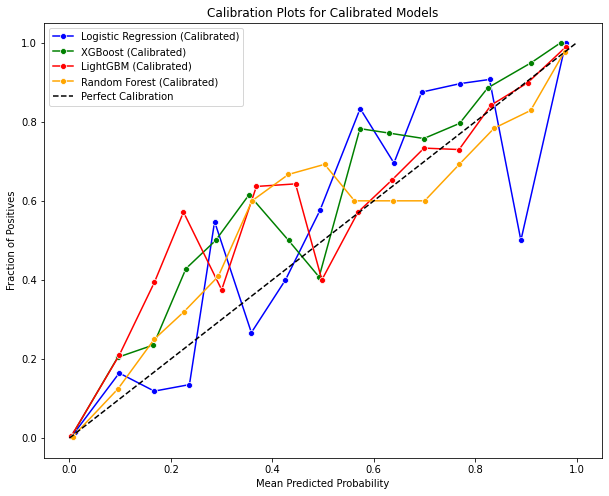

In [63]:
# Generate calibration curves for each calibrated model
xgb_calibrated_prob_true, xgb_calibrated_prob_pred = calibration_curve(y_val, xgb_calibrated_predicts, n_bins=CALIB_BINS)
logreg_calibrated_prob_true, logreg_calibrated_prob_pred = calibration_curve(y_val, logreg_calibrated_predicts, n_bins=CALIB_BINS)
lgbm_calibrated_prob_true, lgbm_calibrated_prob_pred = calibration_curve(y_val, lgbm_calibrated_predicts, n_bins=CALIB_BINS)
rf_calibrated_prob_true, rf_calibrated_prob_pred = calibration_curve(y_val, rf_calibrated_predicts, n_bins=CALIB_BINS)

# Plot calibration curves for calibrated models
plt.figure(figsize=(10, 8))

sns.lineplot(x=logreg_calibrated_prob_pred, y=logreg_calibrated_prob_true, marker='o', label='Logistic Regression (Calibrated)', color='blue')
sns.lineplot(x=xgb_calibrated_prob_pred, y=xgb_calibrated_prob_true, marker='o', label='XGBoost (Calibrated)', color='green')
sns.lineplot(x=lgbm_calibrated_prob_pred, y=lgbm_calibrated_prob_true, marker='o', label='LightGBM (Calibrated)', color='red')
sns.lineplot(x=rf_calibrated_prob_pred, y=rf_calibrated_prob_true, marker='o', label='Random Forest (Calibrated)', color='orange')

plt.plot([0, 1], [0, 1], linestyle='--', color='black', label='Perfect Calibration')

plt.xlabel('Mean Predicted Probability')
plt.ylabel('Fraction of Positives')
plt.title('Calibration Plots for Calibrated Models')
plt.legend(loc='upper left')

plt.show()

In [64]:
# Compute and print ECE for each calibrated model
xgb_calibrated_ece = compute_ece(xgb_calibrated_prob_true, xgb_calibrated_prob_pred, n_bins=CALIB_BINS)
logreg_calibrated_ece = compute_ece(logreg_calibrated_prob_true, logreg_calibrated_prob_pred, n_bins=CALIB_BINS)
lgbm_calibrated_ece = compute_ece(lgbm_calibrated_prob_true, lgbm_calibrated_prob_pred, n_bins=CALIB_BINS)
rf_calibrated_ece = compute_ece(rf_calibrated_prob_true, rf_calibrated_prob_pred, n_bins=CALIB_BINS)

print(f"ECE for Calibrated Logistic Regression: {logreg_calibrated_ece:.4f}")
print(f"ECE for Calibrated XGBoost: {xgb_calibrated_ece:.4f}")
print(f"ECE for Calibrated LightGBM: {lgbm_calibrated_ece:.4f}")
print(f"ECE for Calibrated Random Forest: {rf_calibrated_ece:.4f}")

ECE for Calibrated Logistic Regression: 0.1196
ECE for Calibrated XGBoost: 0.1049
ECE for Calibrated LightGBM: 0.0961
ECE for Calibrated Random Forest: 0.0917


**Observations**:
For some reason, ECE increased almost for all cases except  LightGBM. This sounds promissing since LightGBM is the best according to F1 score and we improved its calibration a bit. We need to compare the metrics and make decision.

## LeaderBoard

In [69]:
# Calculate the best threshold for each model
logreg_best_t = find_best_threshold(y_val, logreg_val_predicts)
xgb_best_t = find_best_threshold(y_val, xgb_model_val_predicts)
lgbm_best_t = find_best_threshold(y_val, lgbm_model_val_predicts)
rf_best_t = find_best_threshold(y_val, rf_model_val_predicts)

logreg_calibrated_best_t = find_best_threshold(y_val, logreg_calibrated_predicts)
xgb_calibrated_best_t = find_best_threshold(y_val, xgb_calibrated_predicts)
lgbm_calibrated_best_t = find_best_threshold(y_val, lgbm_calibrated_predicts)
rf_calibrated_best_t = find_best_threshold(y_val, rf_calibrated_predicts)


In [70]:
# Make predictions using the best thresholds
logreg_preds_best_t = (logreg_val_predicts >= logreg_best_t).astype(int)
xgb_preds_best_t = (xgb_model_val_predicts >= xgb_best_t).astype(int)
lgbm_preds_best_t = (lgbm_model_val_predicts >= lgbm_best_t).astype(int)
rf_preds_best_t = (rf_model_val_predicts >= rf_best_t).astype(int)

logreg_calibrated_preds_best_t = (logreg_calibrated_predicts >= logreg_calibrated_best_t).astype(int)
xgb_calibrated_preds_best_t = (xgb_calibrated_predicts >= xgb_calibrated_best_t).astype(int)
lgbm_calibrated_preds_best_t = (lgbm_calibrated_predicts >= lgbm_calibrated_best_t).astype(int)
rf_calibrated_preds_best_t = (rf_calibrated_predicts >= rf_calibrated_best_t).astype(int)


In [71]:
# Calculate F1-score for models using best thresholds
logreg_f1_best_t = f1_score(y_val, logreg_preds_best_t)
xgb_f1_best_t = f1_score(y_val, xgb_preds_best_t)
lgbm_f1_best_t = f1_score(y_val, lgbm_preds_best_t)
rf_f1_best_t = f1_score(y_val, rf_preds_best_t)

logreg_calibrated_f1_best_t = f1_score(y_val, logreg_calibrated_preds_best_t)
xgb_calibrated_f1_best_t = f1_score(y_val, xgb_calibrated_preds_best_t)
lgbm_calibrated_f1_best_t = f1_score(y_val, lgbm_calibrated_preds_best_t)
rf_calibrated_f1_best_t = f1_score(y_val, rf_calibrated_preds_best_t)


In [77]:
f1_scores_best_t = [
    logreg_f1_best_t,
    xgb_f1_best_t,
    lgbm_f1_best_t,
    rf_f1_best_t,
    logreg_calibrated_f1_best_t,
    xgb_calibrated_f1_best_t,
    lgbm_calibrated_f1_best_t,
    rf_calibrated_f1_best_t
]
best_thresholds = [
    logreg_best_t,
    xgb_best_t,
    lgbm_best_t,
    rf_best_t,
    logreg_calibrated_best_t,
    xgb_calibrated_best_t,
    lgbm_calibrated_best_t,
    rf_calibrated_best_t
]

# Create DataFrame with F1-scores, ECEs, and best thresholds
leaderboard_df_best_t = pd.DataFrame({
    'Model Name': models,
    'F1': f1_scores_best_t,
    'ECE': ece_scores,
    'Best Threshold': best_thresholds
}).sort_values(by="F1", ascending=False)



In [80]:
leaderboard_df_best_t.to_csv("artifacts/leaderboard_df.csv", index=False)
leaderboard_df_best_t.head(10)


Model Name        F1       ECE  Best Threshold
2                        LightGBM  0.835580  0.110561            0.24
6             Calibrated LightGBM  0.834667  0.096057            0.18
3                   Random Forest  0.830393  0.078942            0.24
7        Calibrated Random Forest  0.826923  0.091747            0.26
1                         XGBoost  0.825352  0.059833            0.35
5              Calibrated XGBoost  0.822069  0.104903            0.24
4  Calibrated Logistic Regression  0.689560  0.119644            0.26
0             Logistic Regression  0.652903  0.080202            0.19

In [81]:
#SAVE INFERENCE DATA

train_df_reduced.to_csv("train/splits/train_reduced.csv", index=False)
val_df_reduced.to_csv("train/splits/val_reduced.csv", index=False)
test_df_reduced.to_csv("train/splits/test_reduced.csv", index=False)


In [83]:
import os
save_dir = "./artifacts/"

# Save each model to the /artifacts directory
joblib.dump(logreg, os.path.join(save_dir, 'logistic_regression_model.pkl'))
joblib.dump(xgb_model, os.path.join(save_dir, 'xgboost_model.pkl'))
joblib.dump(lgbm_model, os.path.join(save_dir, 'lightgbm_model.pkl'))
joblib.dump(rf_model, os.path.join(save_dir, 'random_forest_model.pkl'))

joblib.dump(logreg_calibrated_clf, os.path.join(save_dir, 'calibrated_logistic_regression_model.pkl'))
joblib.dump(xgb_calibrated_clf, os.path.join(save_dir, 'calibrated_xgboost_model.pkl'))
joblib.dump(lgbm_calibrated_clf, os.path.join(save_dir, 'calibrated_lightgbm_model.pkl'))
joblib.dump(rf_calibrated_clf, os.path.join(save_dir, 'calibrated_random_forest_model.pkl'))


['./artifacts/calibrated_random_forest_model.pkl']